## regime-switching autoregressive conditional heteroscedasticity (SWARCH) model

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from arch import arch_model
import yfinance as yf
from datetime import datetime, timedelta

In [85]:
def fit_markov_switching_model(returns, k_regimes=3):
    """
    Fit a Markov-switching model to the return series
    """
    returns_centered = returns - returns.mean()
    
    model = MarkovRegression(returns_centered, k_regimes=k_regimes,
                            trend='c', switching_variance=True)
    result = model.fit()

    return result

def compute_regime_probabilities(model_result, returns):
    """
    Compute smoothed probabilities of each regime
    """
    smoothed_probs = model_result.smoothed_marginal_probabilities
    regime_probs = pd.DataFrame(smoothed_probs,
                              index=returns.index,
                              columns=[f'regime_{i}' for i in range(model_result.k_regimes)])

    regime_probs.columns = ['low_volatility', 'medium_volatility', 'high_volatility']

    return regime_probs

def fit_swarch_model(returns):
    # Fit a standard GARCH model to get volatility estimates
    returns = returns.dropna()

    garch_model = arch_model(returns, vol='Garch', p=1, q=1, dist='t')
    garch_result = garch_model.fit(disp='off')

    # Get conditional volatility (annualized)
    conditional_vol = garch_result.conditional_volatility * np.sqrt(52)

    low_thresh = 12  # Approximate threshold for low volatility regime
    high_thresh = 20  # Approximate threshold for high volatility regime

    # regime indicators
    regimes = pd.Series(1, index=returns.index)  # Default to medium regime
    regimes[conditional_vol <= low_thresh] = 0   # Low volatility regime
    regimes[conditional_vol > high_thresh] = 2   # High volatility regime

    # Create regime probabilities (simplified approach)
    low_prob = (regimes == 0).astype(float)
    med_prob = (regimes == 1).astype(float)
    high_prob = (regimes == 2).astype(float)

    regime_probs = pd.DataFrame({
        'low_volatility': low_prob,
        'medium_volatility': med_prob,
        'high_volatility': high_prob
    }, index=returns.index)

    return garch_result, conditional_vol, regime_probs

def get_regime_periods(regime_indicator):
    """
    Helper function to identify continuous periods of a regime
    """
    periods = []
    current_start = None
    # Make sure index is sorted
    regime_indicator = regime_indicator.sort_index()

    for date, value in regime_indicator.items():
        if value and current_start is None:
            current_start = date
        elif not value and current_start is not None:
            # Ensure end date is after start date
            if date > current_start:
                 # Use previous date as end to avoid overlapping spans
                 end_date_period = regime_indicator.index[regime_indicator.index.get_loc(date) - 1] if regime_indicator.index.get_loc(date) > 0 else date
                 periods.append((current_start, end_date_period))
            current_start = None

    # Don't forget the last period if it's still open and valid
    if current_start is not None and regime_indicator.index[-1] >= current_start:
        periods.append((current_start, regime_indicator.index[-1]))

    return periods

def plot_results(returns, conditional_vol, regime_probs, start_date=None, end_date=None):
    """
    Create a plot showing volatility regimes and estimated volatility.
    Optionally adds VIX and regime shading if start_date is provided.
    """
    # --- Filter data based on provided dates ---
    if start_date:
        try:
            # Ensure datetime objects for comparison if strings are passed
            effective_start = pd.to_datetime(start_date)
            effective_end = pd.to_datetime(end_date) if end_date else datetime.now()

            # Filter dataframes - Use .loc for safety
            returns_plot = returns.loc[effective_start:effective_end].copy()
            conditional_vol_plot = conditional_vol.loc[effective_start:effective_end].copy()
            regime_probs_plot = regime_probs.loc[effective_start:effective_end].copy()

            plot_title = 'Estimated Stock Return Volatility and VIX (Recent Period)'
            plot_vix = True # Flag to plot VIX for recent period
            shade_regimes = True # Flag to shade regimes for recent period

        except Exception as e:
            print(f"Error filtering data for plot: {e}. Plotting full range instead.")
            returns_plot = returns.copy()
            conditional_vol_plot = conditional_vol.copy()
            regime_probs_plot = regime_probs.copy()
            plot_title = 'Stock Market Volatility Regimes (Full Period)'
            plot_vix = False
            shade_regimes = False
    else:
        # Use the full data if no start_date provided
        returns_plot = returns.copy()
        conditional_vol_plot = conditional_vol.copy()
        regime_probs_plot = regime_probs.copy()
        plot_title = 'Stock Market Volatility Regimes (Full Period)'
        plot_vix = False
        shade_regimes = False

    # Ensure data is not empty after filtering
    if conditional_vol_plot.empty:
        print("No data available for the specified plot range.")
        return

    # --- Create the plot ---
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot stacked regime probabilities
    regime_probs_stacked = regime_probs_plot.copy()
    # Cumulative sum for stacking
    regime_probs_stacked['medium_volatility_top'] = regime_probs_stacked['low_volatility'] + regime_probs_stacked['medium_volatility']
    regime_probs_stacked['high_volatility_top'] = regime_probs_stacked['medium_volatility_top'] + regime_probs_stacked['high_volatility']

    # Normalize probabilities to sum to 1 if they don't (can happen with simplified model)
    prob_sum = regime_probs_stacked[['low_volatility', 'medium_volatility', 'high_volatility']].sum(axis=1)
    for col in ['low_volatility', 'medium_volatility_top', 'high_volatility_top']:
         # Avoid division by zero if sum is zero
         regime_probs_stacked[col] = np.divide(regime_probs_stacked[col], prob_sum,
                                               out=np.zeros_like(regime_probs_stacked[col]), where=prob_sum!=0)


    ax.fill_between(regime_probs_stacked.index, 0, regime_probs_stacked['low_volatility'] * 100,
                   color='lightgreen', alpha=0.6, label='Low-volatility regime prob.') # Lighter colors
    ax.fill_between(regime_probs_stacked.index, regime_probs_stacked['low_volatility'] * 100,
                   regime_probs_stacked['medium_volatility_top'] * 100,
                   color='moccasin', alpha=0.6, label='Medium-volatility regime prob.') # Lighter colors
    ax.fill_between(regime_probs_stacked.index, regime_probs_stacked['medium_volatility_top'] * 100,
                   regime_probs_stacked['high_volatility_top'] * 100,
                   color='lightcoral', alpha=0.6, label='High-volatility regime prob.') # Lighter colors


    # Plot conditional volatility on secondary axis
    ax2 = ax.twinx()
    line_vol, = ax2.plot(conditional_vol_plot.index, conditional_vol_plot, color='blue', lw=1.5, label='Estimated volatility')

    # --- Conditionally add VIX and Regime Shading ---
    lines_for_legend = [line_vol] # Start legend with volatility line
    labels_for_legend = ['Estimated volatility']

    if plot_vix:
        # Get VIX data for the specific plot range
        try:
            # Use the actual start/end of the data being plotted
            vix_start_date = conditional_vol_plot.index.min().strftime('%Y-%m-%d')
            vix_end_date = conditional_vol_plot.index.max().strftime('%Y-%m-%d')

            vix = yf.download('^VIX', start=vix_start_date, end=vix_end_date)['Close']
            if not vix.empty:
                 # Align VIX to the weekly frequency of the plot
                 # Reindex and forward fill to match the conditional_vol_plot index
                 vix_aligned = vix.reindex(conditional_vol_plot.index, method='ffill')
                 line_vix, = ax2.plot(vix_aligned.index, vix_aligned, 'k--', label='VIX')
                 lines_for_legend.append(line_vix)
                 labels_for_legend.append('VIX')
            else:
                 print("VIX data download was empty for the specified range.")

        except Exception as e:
            print(f"Could not fetch or plot VIX data: {e}")

    if shade_regimes:
        # Shade background according to dominant regime
        dominant_regime = regime_probs_plot.idxmax(axis=1)
        low_vol_periods = dominant_regime == 'low_volatility'
        med_vol_periods = dominant_regime == 'medium_volatility'
        high_vol_periods = dominant_regime == 'high_volatility'

        # Shade regions where each regime is dominant
        # Use different alpha for shading to see probabilities underneath
        alpha_shade = 0.15
        for idx, (start_p, end_p) in enumerate(get_regime_periods(low_vol_periods)):
             ax2.axvspan(start_p, end_p, color='green', alpha=alpha_shade, lw=0) # Use ax2 for shading behind lines

        for idx, (start_p, end_p) in enumerate(get_regime_periods(med_vol_periods)):
             ax2.axvspan(start_p, end_p, color='orange', alpha=alpha_shade, lw=0)

        for idx, (start_p, end_p) in enumerate(get_regime_periods(high_vol_periods)):
             ax2.axvspan(start_p, end_p, color='red', alpha=alpha_shade, lw=0)


    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Regime probabilities (%)')
    ax2.set_ylabel('Annualized volatility (%)')
    ax.set_ylim(0, 100) # Probabilities are 0-100
    ax2.set_ylim(bottom=0) # Volatility starts at 0
    plt.title(plot_title)

    # Add legend from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    # Use the collected lines/labels for ax2
    ax.legend(lines1 + lines_for_legend, labels1 + labels_for_legend, loc='upper left')

    plt.tight_layout()
    plt.show()


def calculate_regime_statistics(returns, regime_probs):

    # Make sure we're working with clean data and aligned indices
    common_index = returns.dropna().index.intersection(regime_probs.index)
    returns_aligned = returns.loc[common_index]
    regime_probs_aligned = regime_probs.loc[common_index]

    if returns_aligned.empty:
        print("No overlapping data between returns and regime probabilities for statistics.")
        return

    # Determine the dominant regime for each time period
    dominant_regime = regime_probs_aligned.idxmax(axis=1)

    # Calculate volatility for each regime
    low_vol = returns_aligned[dominant_regime == 'low_volatility'].std(ddof=1) * np.sqrt(52)
    med_vol = returns_aligned[dominant_regime == 'medium_volatility'].std(ddof=1) * np.sqrt(52)
    high_vol = returns_aligned[dominant_regime == 'high_volatility'].std(ddof=1) * np.sqrt(52)

    # Calculate frequency of each regime
    regime_counts = dominant_regime.value_counts(normalize=True) * 100
    low_freq = regime_counts.get('low_volatility', 0)
    med_freq = regime_counts.get('medium_volatility', 0)
    high_freq = regime_counts.get('high_volatility', 0)

    # Calculate average duration of each regime (in weeks)
    low_dur = calculate_avg_duration(dominant_regime == 'low_volatility')
    med_dur = calculate_avg_duration(dominant_regime == 'medium_volatility')
    high_dur = calculate_avg_duration(dominant_regime == 'high_volatility')

    # Print statistics
    print("\nRegime Statistics:")
    print(f"Low volatility regime:    {low_vol:.1f}% volatility, {low_freq:.1f}% frequency, {low_dur:.1f} weeks avg duration")
    print(f"Medium volatility regime: {med_vol:.1f}% volatility, {med_freq:.1f}% frequency, {med_dur:.1f} weeks avg duration")
    print(f"High volatility regime:   {high_vol:.1f}% volatility, {high_freq:.1f}% frequency, {high_dur:.1f} weeks avg duration")

def calculate_avg_duration(regime_indicator):
    """
    Calculate average duration of regimes (periods where indicator is True)
    """
    # Find changes: True->False or False->True
    # Pad with False at start/end to catch regimes at edges
    padded_indicator = pd.concat([pd.Series([False]), regime_indicator, pd.Series([False])])
    diffs = padded_indicator.astype(int).diff()
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0]

    if len(starts) == 0 or len(ends) == 0:
        return 0 # No complete regimes found

    # Calculate durations
    # Adjust indices because of padding: ends index corresponds to the *end* of the True sequence
    durations = ends - starts

    return np.mean(durations) if len(durations) > 0 else 0


[*********************100%***********************]  1 of 1 completed

Fetching ^GSPC data from Yahoo Finance...
Data loaded: 436 weekly observations from 2017-01-13 to 2025-05-16





Regime Statistics:
Low volatility regime:    9.3% volatility, 37.8% frequency, 6.6 weeks avg duration
Medium volatility regime: 17.4% volatility, 38.8% frequency, 3.9 weeks avg duration
High volatility regime:   27.0% volatility, 23.4% frequency, 4.9 weeks avg duration


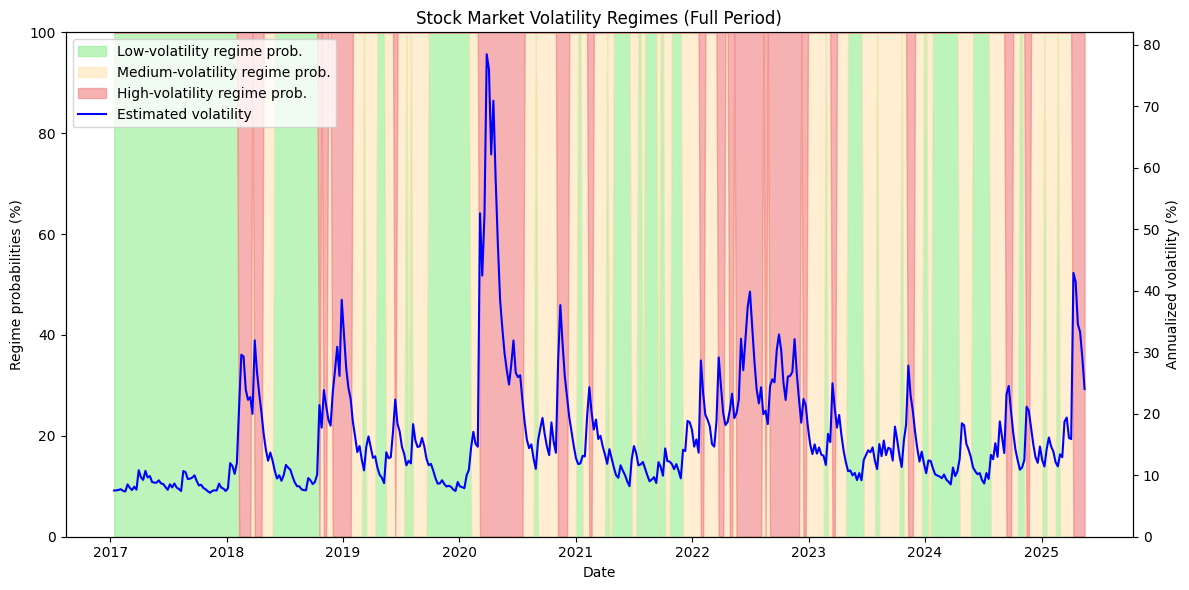

[*********************100%***********************]  1 of 1 completed


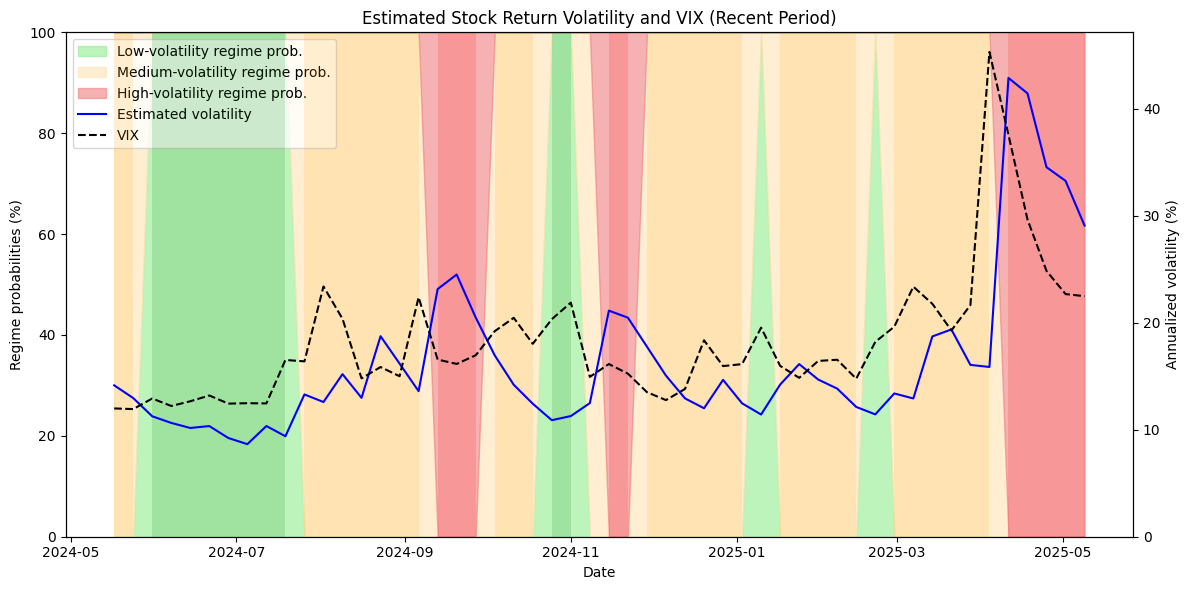

In [86]:
def main():
    # Fetch data using yfinance
    ticker = '^GSPC'  # Imput ticker
    print(f"Fetching {ticker} data from Yahoo Finance...")
    
    # Download data from 1928 or earliest available
    stock = yf.download(ticker, start=start_date)['Close']
    
    # Resample to weekly and calculate returns
    stock_weekly = stock.resample('W-FRI').last()
    stock_weekly = pd.DataFrame(stock_weekly)  # Convert Series to DataFrame
    stock_weekly.columns = ['Close']  # Rename column
    stock_weekly['returns'] = stock_weekly['Close'].pct_change() * 100
    
    # Remove NaN values
    stock_weekly = stock_weekly.dropna()
    
    returns = stock_weekly['returns']
    
    print(f"Data loaded: {len(returns)} weekly observations from {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")
    print('\n')
    # Fit SWARCH model (simplified version)
    garch_result, conditional_vol, regime_probs = fit_swarch_model(returns)    
    # Calculate regime statistics
    calculate_regime_statistics(returns, regime_probs)
    
    # Plot results
    plot_results(returns, conditional_vol, regime_probs)
    
    # Plot recent period 
    try:
        recent_start = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
        recent_end = datetime.now().strftime('%Y-%m-%d')
        plot_results(returns, conditional_vol, regime_probs, 
                    start_date=recent_start, end_date=recent_end)
    except Exception as e:
        print(f"Could not create recent period chart: {e}")
        
    return returns, garch_result, conditional_vol, regime_probs


if __name__ == "__main__":
    returns, garch_result, conditional_vol, regime_probs = main()



--- Generating Forecast for next 30 days ---
Forecasting 5 weekly steps...

Forecast Results:
            Forecasted Volatility Predicted Regime
2025-05-02              28.637030  high_volatility
2025-05-09              28.904156  high_volatility
2025-05-16              29.168836  high_volatility
2025-05-23              29.431135  high_volatility
2025-05-30              29.691118  high_volatility

Disclaimer:
 - Forecast is based on the fitted simplified SWARCH (GARCH + Thresholds) model.
 - Assumes model parameters and market dynamics remain stable.
 - GARCH forecasts tend to revert to the long-term average volatility.
 - Real-world volatility can deviate significantly from forecasts.


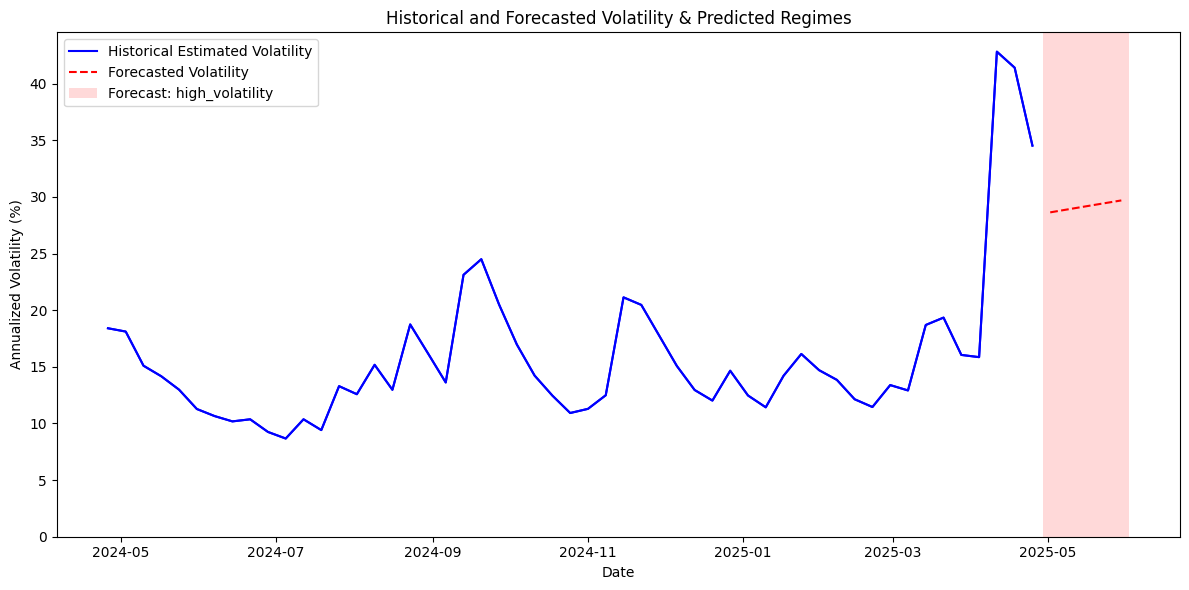

In [79]:

def forecast_volatility_regimes(garch_result, last_returns, low_thresh, high_thresh, forecast_horizon_days=30):
    """
    Forecasts volatility and regimes for a specified number of days ahead.

    Args:
        garch_result: The fitted GARCH model result object from arch.fit().
        last_returns (pd.Series): The most recent returns data used for fitting.
                                     Needed by some forecast methods if using simulation,
                                     but primarily used here to get the last date.
        low_thresh (float): Threshold for low volatility regime.
        high_thresh (float): Threshold for high volatility regime.
        forecast_horizon_days (int): Number of days to forecast ahead.

    Returns:
        pd.DataFrame: A DataFrame containing forecasted volatility and predicted regime.
    """
    print(f"\n--- Generating Forecast for next {forecast_horizon_days} days ---")

    # --- 1. Forecast Volatility using the GARCH model ---
    # Calculate the number of weekly steps needed
    # Use ceil to ensure we cover the full number of days
    steps = int(np.ceil(forecast_horizon_days / 7))
    print(f"Forecasting {steps} weekly steps...")

    # Use the forecast method of the fitted GARCH result
    # 'reindex=False' gives direct step-ahead forecasts without aligning to an index
    forecasts = garch_result.forecast(horizon=steps, reindex=False)

    # Extract the forecasted conditional variance (h.1, h.2, ...)
    # .values[0] accesses the first row (and typically only row) of forecast results
    forecasted_variance = forecasts.variance.values[0]

    # Convert variance to annualized volatility
    forecasted_volatility_annualized = np.sqrt(forecasted_variance) * np.sqrt(52)

    # --- 2. Create Future Date Index ---
    last_date = last_returns.index[-1]
    # Generate weekly dates starting from the week AFTER the last known date
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=steps, freq='W-FRI')

    # Create a Series for the forecasted volatility
    forecasted_vol_series = pd.Series(forecasted_volatility_annualized, index=future_dates, name='Forecasted Volatility')

    # --- 3. Predict Regimes based on Forecasted Volatility ---
    # Apply the same threshold logic used in fit_swarch_model
    predicted_regimes_numeric = pd.Series(1, index=future_dates)  # Default to medium (1)
    predicted_regimes_numeric[forecasted_vol_series <= low_thresh] = 0 # Low (0)
    predicted_regimes_numeric[forecasted_vol_series > high_thresh] = 2  # High (2)

    # Map numeric regimes to labels
    regime_map = {0: 'low_volatility', 1: 'medium_volatility', 2: 'high_volatility'}
    predicted_regimes_labels = predicted_regimes_numeric.map(regime_map)
    predicted_regimes_labels.name = 'Predicted Regime'

    # --- 4. Combine Results ---
    forecast_df = pd.concat([forecasted_vol_series, predicted_regimes_labels], axis=1)

    print("\nForecast Results:")
    print(forecast_df)

    # --- 5. Disclaimer ---
    print("\nDisclaimer:")
    print(" - Forecast is based on the fitted simplified SWARCH (GARCH + Thresholds) model.")
    print(" - Assumes model parameters and market dynamics remain stable.")
    print(" - GARCH forecasts tend to revert to the long-term average volatility.")
    print(" - Real-world volatility can deviate significantly from forecasts.")

    return forecast_df

def plot_forecast(conditional_vol, forecast_df):
    """
    Plots the recent historical volatility and the forecasted volatility.
    """
    if forecast_df.empty:
        print("Forecast DataFrame is empty, cannot plot.")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot recent historical volatility (e.g., last year)
    if not conditional_vol.empty:
        start_date_plot = conditional_vol.index.max() - pd.DateOffset(weeks=52)
        # Use .loc slicing - handles cases where data is shorter than 52 weeks
        recent_hist_vol = conditional_vol.loc[start_date_plot:]
        ax.plot(recent_hist_vol.index, recent_hist_vol, label='Historical Estimated Volatility', color='blue')
    else:
        print("Conditional volatility data is empty, cannot plot historical part.")
    ax.plot(recent_hist_vol.index, recent_hist_vol, label='Historical Estimated Volatility', color='blue')

    # Plot forecasted volatility
    ax.plot(forecast_df.index, forecast_df['Forecasted Volatility'], label='Forecasted Volatility', color='red', linestyle='--')

    alpha_shade = 0.15
    for regime, color in [('low_volatility', 'green'), ('medium_volatility', 'orange'), ('high_volatility', 'red')]:
        regime_periods = forecast_df[forecast_df['Predicted Regime'] == regime]
        if not regime_periods.empty:
             # Simple way to shade: iterate through forecast points
             # More robust: group consecutive dates and use axvspan
             start_p = None
             for date in regime_periods.index:
                 if start_p is None: start_p = date
                 # If next date isn't consecutive week or it's the last point, draw span
                 next_date_expected = date + pd.Timedelta(weeks=1)
                 if (date == regime_periods.index[-1]) or (forecast_df.index[forecast_df.index.get_loc(date) + 1] != next_date_expected) :
                      end_p = date + pd.Timedelta(days=3) # Extend span slightly for visibility
                      ax.axvspan(start_p - pd.Timedelta(days=3), end_p, color=color, alpha=alpha_shade, lw=0, label=f'Forecast: {regime}' if start_p == regime_periods.index[0] else "") # Label only first span
                      start_p = None


    ax.set_ylabel('Annualized Volatility (%)')
    ax.set_xlabel('Date')
    ax.set_title('Historical and Forecasted Volatility & Predicted Regimes')

    # Improve legend handling - avoid duplicate labels from axvspan
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles)) # Use dict to automatically remove duplicates
    ax.legend(by_label.values(), by_label.keys(), loc='upper left')

    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()


# Define the thresholds used in fit_swarch_model
low_thresh_forecast = 12
high_thresh_forecast = 20

if 'garch_result' in locals() or 'garch_result' in globals():
    # Generate the forecast
    forecast_results = forecast_volatility_regimes(
        garch_result,
        returns, # Pass the returns Series used for fitting
        low_thresh_forecast,
        high_thresh_forecast,
        forecast_horizon_days=30
    )

    # Plot the forecast alongside recent history
    if 'conditional_vol' in locals() or 'conditional_vol' in globals():
        plot_forecast(conditional_vol, forecast_results)
    else:
        print("Variable 'conditional_vol' not found. Cannot plot forecast.")

else:
    print("Variable 'garch_result' not found. Please run the main analysis cell first.")

In [111]:
import warnings
try:
    # For statsmodels >= 0.11
    from statsmodels.tools.sm_exceptions import ConvergenceWarning as StatsmodelsConvergenceWarning
except ImportError:
    # For older statsmodels (e.g., 0.10)
    try:
        from statsmodels.tools.sm_exceptions import ConvergenceWarning as StatsmodelsConvergenceWarning
    except ImportError:
        # If still not found, create a dummy class for the except block
        class StatsmodelsConvergenceWarning(Warning):
            pass

def fit_full_swarch_model(returns, k_regimes=3, ar_order=0, annualization_factor=52):
    """
    Fit a Markov-switching model with regime-dependent variance (and optionally AR coefficients)
    to the return series. This serves as a "full SWARCH-like" model.
    Includes multiple fitting attempts to improve chances of convergence.
    """
    returns_series = returns.dropna()
    if returns_series.empty:
        raise ValueError("Input returns are all NaN after dropping NaNs.")

    if not isinstance(k_regimes, int) or k_regimes <= 0:
        raise ValueError("k_regimes must be a positive integer.")
    if not isinstance(ar_order, int) or ar_order < 0:
        raise ValueError("ar_order must be a non-negative integer.")

    original_series_mean = returns_series.mean()
    returns_centered = returns_series - original_series_mean

    # --- Model Definition Function (to create fresh instances) ---
    def create_model_instance():
        if ar_order > 0:
            # Ensure switching_ar is explicitly True if ar_order > 0 and you want AR params to switch
            return MarkovRegression(
                returns_centered,
                k_regimes=k_regimes,
                trend='c', # Regime-specific intercepts
                switching_variance=True,
                switching_ar=True, # AR coefficients switch by regime
                order=ar_order
            )
        else:
            return MarkovRegression(
                returns_centered,
                k_regimes=k_regimes,
                trend='c',
                switching_variance=True
            )

    model_desc_base = f"MarkovRegression: {k_regimes} regimes, trend='c', switching_variance=True"
    if ar_order > 0:
        model_desc = f"{model_desc_base}, AR({ar_order}) (AR coeffs switch)"
    else:
        model_desc = f"{model_desc_base}, No AR terms"
    
    print(f"Attempting to fit model: {model_desc}")

    result = None
    best_llf = -np.inf # Keep track of the best log-likelihood from non-converged attempts

    # --- Fitting Attempts ---
    fitting_pipeline = [
        {"desc": "Attempt 1: Default optimizer (search_reps=30)", 
         "config": {"search_reps": 30, "disp": False, "maxiter": 1000}},
        {"desc": "Attempt 2: Default optimizer (search_reps=100, more iterations)", 
         "config": {"search_reps": 100, "disp": False, "maxiter": 2000}}, # Increased from 1500
        {"desc": "Attempt 3: Nelder-Mead optimizer (search_reps=50, many iterations)", 
         "config": {"method": 'nm', "search_reps": 50, "disp": False, "maxiter": 3500, "tol": 1e-7}}, # Increased maxiter
        {"desc": "Attempt 4: Fallback with minimal search_reps (5)", 
         "config": {"search_reps": 5, "disp": False, "maxiter": 1000}},
    ]

    for attempt_info in fitting_pipeline:
        print(f"\n--- {attempt_info['desc']} ---")
        current_model_instance = create_model_instance()
        try:
            # Suppress ConvergenceWarning during the fit; we check explicitly after
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=StatsmodelsConvergenceWarning)
                # Also ignore common RuntimeWarnings from optimization like overflow
                warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered")
                warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered")
                
                temp_result = current_model_instance.fit(**attempt_info['config'])
            
            if temp_result.mle_retvals.get('converged', False):
                print(f"Fit converged successfully with: {attempt_info['desc']}. LogL: {temp_result.llf:.2f}")
                result = temp_result
                break # Exit loop on first successful convergence
            else:
                current_llf = temp_result.llf if hasattr(temp_result, 'llf') else -np.inf
                print(f"{attempt_info['desc']} did not converge. LogL: {current_llf:.2f}, Warnflag: {temp_result.mle_retvals.get('warnflag')}")
                if current_llf > best_llf:
                    result = temp_result # Keep the non-converged result with the best LogL
                    best_llf = current_llf
        except Exception as e:
            print(f"Error during {attempt_info['desc']}: {e}")
            # If `result` is still None (e.g. first attempt errors out),
            # and this is the last attempt, the final check for `result is None` will handle it.

    if result is None: 
        raise RuntimeError("Model fitting did not produce a result object after all attempts (all attempts may have errored).")

    # --- Explicitly check for convergence of the best/last result ---
    if not result.mle_retvals.get('converged', False):
        print("\nWARNING: Maximum Likelihood optimization failed to converge even after multiple attempts!")
        print("MLE Retvals (from best non-converged attempt):", result.mle_retvals)
        
        param_names_available = []
        if hasattr(result, 'params') and result.params is not None:
            param_names_available = result.params.index.tolist()
        print("\nAvailable parameters from the best non-converged model:", param_names_available)

        ar_params_fully_available = True 
        if ar_order > 0:
            if not (hasattr(result, 'params') and result.params is not None):
                ar_params_fully_available = False
            else:
                for r_idx in range(k_regimes):
                    for L_idx in range(ar_order):
                        param_name = f'ar.L{L_idx+1}[{r_idx}]'
                        if param_name not in param_names_available:
                            ar_params_fully_available = False
                            break
                    if not ar_params_fully_available:
                        break
        
        try:
            print("\nModel Summary (Partial results from best non-converged attempt):")
            print(result.summary())
        except Exception as summary_err:
            print(f"Could not print model summary for non-converged result: {summary_err}")

        error_message = (
            "Model optimization failed to converge. Parameters may be unreliable or missing. "
        )
        if ar_order > 0 and not ar_params_fully_available:
             error_message += (
                f"Not all AR({ar_order}) parameters were found in the results; this is common with non-convergence. "
            )
        error_message += (
            "Consider simplifying the model (e.g., fewer regimes, AR_ORDER_MODEL=0), "
            "using more data, or different data preprocessing/scaling."
        )
        raise RuntimeError(error_message)
    
    print(f"\nModel converged successfully. Final LogL: {result.llf:.2f}")
    
    # --- Parameter Extraction (Proceeding only if convergence was successful) ---
    try:
        regime_variances_model = np.array([result.params[f'sigma2[{i}]'] for i in range(k_regimes)])
    except KeyError as e:
        raise RuntimeError(f"Converged model is missing expected sigma2 parameters: {e}. Params: {result.params.index.tolist()}") from e

    sorted_regime_indices = np.argsort(regime_variances_model) 

    original_smoothed_probs = result.smoothed_marginal_probabilities 
    # Ensure columns are correctly indexed if original_smoothed_probs.columns are not simple integers
    # Typically, they are 0, 1, ..., k_regimes-1
    # If original_smoothed_probs.columns are already pd.Index of integers [0, 1, ..., k-1]
    # then result.smoothed_marginal_probabilities.iloc[:, sorted_regime_indices] is safer if columns are not standard.
    # However, `original_smoothed_probs[sorted_regime_indices]` works if columns are integer labels.
    # Let's assume standard integer column labels for now.
    sorted_smoothed_probs_array = original_smoothed_probs.iloc[:, sorted_regime_indices].values


    if k_regimes == 1:
        regime_names = ['volatility_regime']
    elif k_regimes == 2:
        regime_names = ['low_volatility', 'high_volatility']
    elif k_regimes == 3:
        regime_names = ['low_volatility', 'medium_volatility', 'high_volatility']
    else:  # k_regimes > 3
        regime_names = ['low_volatility'] + \
                       [f'medium_volatility_{i}' for i in range(1, k_regimes - 1)] + \
                       ['high_volatility']

    regime_probs_df = pd.DataFrame(
        sorted_smoothed_probs_array,
        index=returns_centered.index, # or result.smoothed_marginal_probabilities.index
        columns=regime_names 
    )

    sorted_variances_model_ordered = regime_variances_model[sorted_regime_indices]
    # np.maximum used to prevent sqrt of tiny negative numbers due to precision
    expected_conditional_variance = np.sum(sorted_smoothed_probs_array * sorted_variances_model_ordered, axis=1)
    conditional_vol_series = pd.Series(np.sqrt(np.maximum(0, expected_conditional_variance)), index=regime_probs_df.index)
    conditional_vol_annualized = conditional_vol_series * np.sqrt(annualization_factor)
    
    try:
        model_regime_intercepts_centered = np.array([result.params[f'const[{idx}]'] for idx in sorted_regime_indices])
    except KeyError as e:
        raise RuntimeError(f"Converged model is missing expected const parameters: {e}. Params: {result.params.index.tolist()}") from e
        
    model_regime_stdevs_annualized = np.sqrt(np.maximum(0, sorted_variances_model_ordered)) * np.sqrt(annualization_factor)

    sorted_model_params = {
        'names': regime_names, 
        'model_annualized_stdevs': model_regime_stdevs_annualized,
        'model_weekly_intercepts_centered': model_regime_intercepts_centered,
        'original_series_weekly_mean': original_series_mean,
        'annualization_factor': annualization_factor,
        'ar_order': ar_order 
    }

    if ar_order > 0:
        ar_coeffs_list = []
        all_ar_coeffs_found = True
        for regime_idx_model_internal in sorted_regime_indices: # These are the original 0..k-1 indices, but sorted by variance
            try:
                # AR coeffs for this specific original model regime index
                regime_ar_coeffs = [result.params[f'ar.L{L+1}[{regime_idx_model_internal}]'] for L in range(ar_order)]
                ar_coeffs_list.append(regime_ar_coeffs) 
            except KeyError as e:
                # This block should ideally not be hit if the model truly converged and estimated all AR params
                print(f"WARNING: Converged model appears to be missing an expected AR coefficient: {e}")
                print(f"         Attempted for original model regime index (after sorting): {regime_idx_model_internal}")
                print(f"         Available parameters: {result.params.index.tolist()}")
                ar_coeffs_list.append([np.nan] * ar_order) # Fill with NaNs for this regime
                all_ar_coeffs_found = False
        
        sorted_model_params['model_ar_coeffs'] = ar_coeffs_list

        if not all_ar_coeffs_found:
            print("WARNING: Some AR coefficients were missing even after reported convergence. Long-run means may be incomplete or NaN.")
            sorted_model_params['model_long_run_weekly_means_centered'] = np.array([np.nan] * k_regimes)
        else:
            long_run_means_centered_weekly = []
            for i in range(k_regimes): # i is now index for sorted regimes (0=low_vol, 1=med_vol, etc.)
                intercept = model_regime_intercepts_centered[i] # Already sorted
                current_ar_coeffs = ar_coeffs_list[i] # Already sorted

                if any(np.isnan(c) for c in current_ar_coeffs): # Should be caught by all_ar_coeffs_found
                    long_run_means_centered_weekly.append(np.nan)
                    continue

                phi_sum = np.sum(current_ar_coeffs) 
                
                if abs(1 - phi_sum) < 1e-9: 
                    lrm = intercept / (1 - phi_sum) if (1-phi_sum) != 0 else float('inf') 
                    print(f"Warning: Regime '{regime_names[i]}' AR parameters sum to {phi_sum:.4f} (close to 1). Long-run mean may be unstable or infinite.")
                else:
                    lrm = intercept / (1 - phi_sum)
                long_run_means_centered_weekly.append(lrm)
            sorted_model_params['model_long_run_weekly_means_centered'] = np.array(long_run_means_centered_weekly)

    return result, conditional_vol_annualized, regime_probs_df, sorted_model_params

# --- Helper: Regime Periods (Identifies continuous periods of a regime) ---
def get_regime_periods(regime_indicator):
    """ Identifies continuous periods where regime_indicator is True. """
    periods = []
    current_start = None
    regime_indicator = regime_indicator.sort_index()

    for date, value in regime_indicator.items():
        if value and current_start is None:
            current_start = date
        elif not value and current_start is not None:
            loc_current_date = regime_indicator.index.get_loc(date)
            if loc_current_date > 0:
                 end_date_period = regime_indicator.index[loc_current_date - 1]
                 if end_date_period >= current_start :
                    periods.append((current_start, end_date_period))
            current_start = None
    
    if current_start is not None and regime_indicator.index[-1] >= current_start:
        periods.append((current_start, regime_indicator.index[-1]))
    return periods

# --- Plotting Function (Modified for general k_regimes) ---
def plot_results(returns, conditional_vol, regime_probs, start_date_plot=None, end_date_plot=None):
    """
    Create a plot showing volatility regimes and estimated volatility.
    Generalized for k_regimes.
    """
    if start_date_plot:
        try:
            effective_start = pd.to_datetime(start_date_plot)
            effective_end = pd.to_datetime(end_date_plot) if end_date_plot else datetime.now()
            returns_plot = returns.loc[effective_start:effective_end].copy()
            conditional_vol_plot = conditional_vol.loc[effective_start:effective_end].copy()
            regime_probs_plot = regime_probs.loc[effective_start:effective_end].copy()
            plot_title = 'Estimated Stock Return Volatility and VIX (Recent Period)'
            plot_vix = True; shade_regimes = True
        except Exception as e:
            print(f"Error filtering data for plot: {e}. Plotting full range instead.")
            returns_plot = returns.copy(); conditional_vol_plot = conditional_vol.copy(); regime_probs_plot = regime_probs.copy()
            plot_title = 'Stock Market Volatility Regimes (Full Period)'
            plot_vix = False; shade_regimes = False
    else:
        returns_plot = returns.copy(); conditional_vol_plot = conditional_vol.copy(); regime_probs_plot = regime_probs.copy()
        plot_title = 'Stock Market Volatility Regimes (Full Period)'
        plot_vix = False; shade_regimes = False

    if conditional_vol_plot.empty:
        print("No data available for the specified plot range.")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    current_bottom = pd.Series(0.0, index=regime_probs_plot.index)
    regime_name_to_fill_color = {
        'low_volatility': 'lightgreen',
        'medium_volatility': 'moccasin',
        'high_volatility': 'lightcoral',
    }
    generic_fill_colors = ['lightblue', 'lightpink', 'lightgray', 'paleturquoise', 'lavender']
    color_idx_generic_fill = 0

    for i, regime_col_name in enumerate(regime_probs_plot.columns):
        prob_series = regime_probs_plot[regime_col_name]
        current_top = current_bottom + prob_series * 100
        
        fill_color = regime_name_to_fill_color.get(regime_col_name)
        if fill_color is None:
            if 'medium_volatility' in regime_col_name and 'medium_volatility' in regime_name_to_fill_color: 
                fill_color = regime_name_to_fill_color['medium_volatility']
            else:
                fill_color = generic_fill_colors[color_idx_generic_fill % len(generic_fill_colors)]
                color_idx_generic_fill +=1
        
        ax.fill_between(regime_probs_plot.index, current_bottom, current_top,
                        color=fill_color, alpha=0.7, label=f'{regime_col_name.replace("_", " ").title()} Prob.')
        current_bottom = current_top
    
    ax2 = ax.twinx()
    line_vol, = ax2.plot(conditional_vol_plot.index, conditional_vol_plot, color='blue', lw=1.5, label='Estimated Volatility')
    lines_for_legend = [line_vol]; labels_for_legend = ['Estimated Volatility']

    if plot_vix:
        try:
            vix_start_date = conditional_vol_plot.index.min().strftime('%Y-%m-%d')
            vix_end_date = conditional_vol_plot.index.max().strftime('%Y-%m-%d')
            vix_data = yf.download('^VIX', start=vix_start_date, end=vix_end_date, progress=False)['Close']
            if not vix_data.empty:
                vix_aligned = vix_data.reindex(conditional_vol_plot.index, method='ffill')
                line_vix, = ax2.plot(vix_aligned.index, vix_aligned, 'k--', lw=1.5, label='VIX')
                lines_for_legend.append(line_vix); labels_for_legend.append('VIX')
            else: print("VIX data download was empty for the specified range.")
        except Exception as e: print(f"Could not fetch or plot VIX data: {e}")

    if shade_regimes:
        dominant_regime_series = regime_probs_plot.idxmax(axis=1)
        alpha_shade = 0.15
        regime_name_to_shade_color = {
            'low_volatility': 'green', 'medium_volatility': 'orange', 'high_volatility': 'red',
        }
        generic_shade_colors = ['purple', 'brown', 'grey', 'cyan']
        color_idx_generic_shade = 0

        for regime_name in regime_probs_plot.columns:
            is_dominant_period = (dominant_regime_series == regime_name)
            
            shade_color = regime_name_to_shade_color.get(regime_name)
            if shade_color is None:
                if 'medium_volatility' in regime_name and 'medium_volatility' in regime_name_to_shade_color:
                     shade_color = regime_name_to_shade_color['medium_volatility']
                else:
                    shade_color = generic_shade_colors[color_idx_generic_shade % len(generic_shade_colors)]
                    color_idx_generic_shade += 1
            
            for _, (start_p, end_p) in enumerate(get_regime_periods(is_dominant_period)):
                ax2.axvspan(start_p, end_p, color=shade_color, alpha=alpha_shade, lw=0)

    ax.set_xlabel('Date')
    ax.set_ylabel('Regime Probabilities (%)')
    ax2.set_ylabel('Annualized Volatility (%)')
    ax.set_ylim(0, 100); ax2.set_ylim(bottom=0)
    plt.title(plot_title)

    lines1, labels1 = ax.get_legend_handles_labels()
    ax.legend(lines1 + lines_for_legend, labels1 + labels_for_legend, loc='upper left')
    plt.tight_layout(); plt.show()

# --- Statistics Calculation (Modified) ---
def calculate_regime_statistics(returns, regime_probs, model_params):
    """ Calculate statistics for each regime using model parameters and ex-post sample data. """
    common_index = returns.dropna().index.intersection(regime_probs.index)
    returns_aligned = returns.loc[common_index]
    regime_probs_aligned = regime_probs.loc[common_index]

    if returns_aligned.empty:
        print("No overlapping data between returns and regime probabilities for statistics."); return

    dominant_regime_series = regime_probs_aligned.idxmax(axis=1)
    
    regime_names_list = model_params['names']
    ann_factor = model_params['annualization_factor']
    orig_series_mean_weekly = model_params['original_series_weekly_mean']
    ar_order_model = model_params['ar_order']
    
    print("\n--- Regime Statistics ---")
    print(f"(Annualization factor: {ann_factor}, AR order for model: {ar_order_model})")

    for i, regime_name_key in enumerate(regime_names_list):
        print(f"\n{regime_name_key.replace('_', ' ').title()}:")
        
        model_vol_ann = model_params['model_annualized_stdevs'][i]
        print(f"  Model-Implied Volatility (ann.): {model_vol_ann:.1f}%")

        if ar_order_model > 0:
            # Check if AR coefficients were successfully extracted and stored
            if 'model_ar_coeffs' not in model_params or \
               len(model_params['model_ar_coeffs']) <= i or \
               len(model_params['model_long_run_weekly_means_centered']) <=i:
                print("  Model-Implied Mean Return (ann.): Could not be determined (AR parameters missing).")
            else:
                model_mean_weekly_centered = model_params['model_long_run_weekly_means_centered'][i]
                ar_coeffs_regime = model_params['model_ar_coeffs'][i]
                model_mean_ann = (model_mean_weekly_centered + orig_series_mean_weekly) * ann_factor
                ar_coeffs_str = ", ".join([f"{c:.3f}" for c in ar_coeffs_regime])
                print(f"  Model-Implied Long-Run Mean Return (ann.): {model_mean_ann:.2f}% (AR Coeffs: [{ar_coeffs_str}])")
        else: # No AR terms
            model_intercept_weekly_centered = model_params['model_weekly_intercepts_centered'][i]
            model_mean_ann = (model_intercept_weekly_centered + orig_series_mean_weekly) * ann_factor
            print(f"  Model-Implied Mean Return (ann.): {model_mean_ann:.2f}%")

        regime_return_subset = returns_aligned[dominant_regime_series == regime_name_key]
        if not regime_return_subset.empty:
            sample_vol_ann = regime_return_subset.std(ddof=1) * np.sqrt(ann_factor)
            sample_mean_ann = regime_return_subset.mean() * ann_factor
            freq_pct = (dominant_regime_series == regime_name_key).mean() * 100
            avg_dur_weeks = calculate_avg_duration(dominant_regime_series == regime_name_key)
            
            print(f"  Sample Volatility (ann., when regime dominant): {sample_vol_ann:.1f}%")
            print(f"  Sample Mean Return (ann., when regime dominant): {sample_mean_ann:.1f}%")
            print(f"  Frequency in Sample (dominant): {freq_pct:.1f}%")
            print(f"  Avg Duration in Sample (dominant): {avg_dur_weeks:.1f} weeks")
        else:
            print(f"  No periods in sample where '{regime_name_key}' was the dominant regime.")
            
# --- Avg Duration Helper (Calculates average length of True periods) ---
def calculate_avg_duration(regime_indicator):
    """ Calculates average duration of periods where regime_indicator is True. """
    if regime_indicator.empty: return 0
    
    idx_start_pad = regime_indicator.index[0] - pd.Timedelta(days=1) if len(regime_indicator.index) > 0 and isinstance(regime_indicator.index, pd.DatetimeIndex) else None
    idx_end_pad = regime_indicator.index[-1] + pd.Timedelta(days=1) if len(regime_indicator.index) > 0 and isinstance(regime_indicator.index, pd.DatetimeIndex) else None

    series_list_for_concat = []
    if idx_start_pad is not None:
        series_list_for_concat.append(pd.Series([False], index=[idx_start_pad]))
    series_list_for_concat.append(regime_indicator)
    if idx_end_pad is not None:
        series_list_for_concat.append(pd.Series([False], index=[idx_end_pad]))
    
    if not series_list_for_concat: return 0 # Should not happen if regime_indicator is not empty
    
    # Robust concatenation for potentially non-DatetimeIndex or mixed types from padding
    if len(series_list_for_concat) == 1 and not isinstance(series_list_for_concat[0].index, pd.DatetimeIndex):
         # Only regime_indicator, no padding was possible or index is not datetime
         padded_indicator = pd.concat([pd.Series([False]), regime_indicator.reset_index(drop=True), pd.Series([False])])
    else:
        try:
            padded_indicator = pd.concat(series_list_for_concat).dropna() # dropna if padding created NaT indices for non-datetime
        except TypeError: # Fallback if concat fails (e.g. mixed types that dropna can't handle this way)
             padded_indicator = pd.concat([pd.Series([False]), regime_indicator.reset_index(drop=True), pd.Series([False])])


    if padded_indicator.empty : return 0

    diffs = padded_indicator.astype(int).diff()
    
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0]

    if len(starts) == 0 or len(ends) == 0: return 0
    
    # Ensure first end is after first start
    current_ends_ptr = 0
    while current_ends_ptr < len(ends) and ends[current_ends_ptr] <= starts[0]:
        current_ends_ptr +=1
    
    valid_ends_slice = ends[current_ends_ptr:]
    if len(valid_ends_slice) == 0 : return 0

    durations = []
    current_s_ptr = 0
    current_e_ptr = 0 # Relative to valid_ends_slice

    while current_s_ptr < len(starts) and current_e_ptr < len(valid_ends_slice):
        s_idx_val = starts[current_s_ptr]
        # Find the first end in valid_ends_slice that is after s_idx_val
        # This logic assumes starts and ends strictly alternate once aligned
        e_idx_val = valid_ends_slice[current_e_ptr]

        if e_idx_val > s_idx_val:
            durations.append(e_idx_val - s_idx_val)
            current_s_ptr += 1
            current_e_ptr += 1
        else: # This case should ideally not be hit if starts/ends alternate
              # This implies an end is not after the current start, advance end pointer
            current_e_ptr += 1 
            # Or, if a start is "skipped", advance start pointer
            # current_s_ptr +=1 # Uncomment if starts can be skipped
            
    return np.mean(durations) if len(durations) > 0 else 0

# --- Main Execution ---
def main():
    # --- Configuration ---
    TICKER = '^GSPC'
    START_DATE_DATA = "2015-01-01"
    K_REGIMES_MODEL = 3
    AR_ORDER_MODEL = 1
    ANNUALIZATION_FACTOR = 52

    print(f"Fetching {TICKER} data from Yahoo Finance (from {START_DATE_DATA})...")
    stock_data_daily = yf.download(TICKER, start=START_DATE_DATA, progress=False)['Close']
    
    if stock_data_daily.empty:
        print(f"No data downloaded for {TICKER}. Exiting.")
        return

    stock_data_weekly = stock_data_daily.resample('W-FRI').last()
    returns_weekly = stock_data_weekly.pct_change() * 100
    returns_weekly = returns_weekly.dropna()
    
    if returns_weekly.empty:
        print("Not enough data to calculate weekly returns after processing. Exiting.")
        return
        
    print(f"Data loaded: {len(returns_weekly)} weekly observations from {returns_weekly.index[0].strftime('%Y-%m-%d')} to {returns_weekly.index[-1].strftime('%Y-%m-%d')}\n")

    try:
        ms_result, cond_vol, regime_probs_df, model_params_dict = fit_full_swarch_model(
            returns_weekly,
            k_regimes=K_REGIMES_MODEL,
            ar_order=AR_ORDER_MODEL,
            annualization_factor=ANNUALIZATION_FACTOR
        )

        calculate_regime_statistics(returns_weekly, regime_probs_df, model_params_dict)

        print("\nPlotting full period results...")
        plot_results(returns_weekly, cond_vol, regime_probs_df)

        print("\nPlotting recent period results...")
        try:
            num_years_recent_plot = 10
            end_date_recent_plot = returns_weekly.index[-1]
            start_date_recent_plot = end_date_recent_plot - pd.DateOffset(years=num_years_recent_plot)
            start_date_recent_plot = max(start_date_recent_plot, returns_weekly.index[0])

            plot_results(returns_weekly, cond_vol, regime_probs_df,
                         start_date_plot=start_date_recent_plot.strftime('%Y-%m-%d'), 
                         end_date_plot=end_date_recent_plot.strftime('%Y-%m-%d'))
        except Exception as e_plot_recent:
            print(f"Could not create recent period chart: {e_plot_recent}")

    except RuntimeError as e_runtime: # Catch the explicit RuntimeError from fit_full_swarch_model
        print(f"\nExecution halted due to model fitting error: {e_runtime}")
    except Exception as e_main: # Catch any other unexpected errors in main
        print(f"\nAn unexpected error occurred in main: {e_main}")
        
if __name__ == "__main__":
    main()

Fetching ^GSPC data from Yahoo Finance (from 2015-01-01)...
Data loaded: 541 weekly observations from 2015-01-09 to 2025-05-16

Attempting to fit model: MarkovRegression: 3 regimes, trend='c', switching_variance=True, AR(1) (AR coeffs switch)

--- Attempt 1: Default optimizer (search_reps=30) ---

An unexpected error occurred in main: MarkovRegression.__init__() got an unexpected keyword argument 'switching_ar'
